In [1]:
#Import bibliotek

In [1]:
import pickle
import gc
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import signal
from scipy.signal import welch
from __future__ import print_function
import numpy as np
from scipy.integrate import simps
import pandas as pd
from keras import models
from keras import layers
import tensorflow as tf
%matplotlib inline

In [3]:
#Wczytywanie datasetu i zapisywanie w zmiennej all_sub_data

In [2]:
def convert_transpose(subject_data):
    dataset = []
    for i in range(subject_data.shape[0]):
        dataset.append(subject_data[i].T)
    dataset = np.array(dataset)
    return dataset
def arousal_valence(arousal,valence):
    """
    0 - high arousal, high valence
    1 - high arousal, low valence
    2 - low arousal, high valence
    3 - low arousal, low valence
    """
    if arousal > 5 and valence > 5:
        return 0
    if arousal > 5 and valence <= 5:
        return 1
    if arousal <=5 and valence > 5:
        return 2
    if arousal <=5 and valence <= 5:
        return 3


all_sub_data = []
all_sub_labels_arousal = []
all_sub_labels_valence = []
all_sub_labels_ar_val = []
channels = 32
vids_per_sub = 40
subjects_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
for sub in subjects_list:
    path = '../data_preprocessed_python/'+"\\s"+sub+".dat"
    x = pickle.load(open(path, 'rb'), encoding = 'latin1')
    sub_data = x['data']
    sub_label = x['labels']
    sub_eeg = sub_data[:, :channels, :7680]
    sub_eeg = convert_transpose(sub_eeg)
    for video in range(vids_per_sub):
        
        one_video_X = sub_eeg[video]

        valence = 1 if sub_label[video][0] > 5 else 0
        arousal = 1 if sub_label[video][1] > 5 else 0
        arr_val = arousal_valence(sub_label[video][1], sub_label[video][0])

        label_for_vid_arousal = np.array([arousal])
        label_for_vid_valence = np.array([valence])
        label_for_vid_ar_val = np.array([arr_val])

        all_sub_data.append(one_video_X)
        all_sub_labels_arousal.append(label_for_vid_arousal)
        all_sub_labels_valence.append(label_for_vid_valence)
        all_sub_labels_ar_val.append(label_for_vid_ar_val)
            
    gc.collect()
gc.collect()

all_sub_data = np.array(all_sub_data)
all_sub_labels_arousal = np.array(all_sub_labels_arousal)
all_sub_labels_valence = np.array(all_sub_labels_valence)
all_sub_labels_ar_val = np.array(all_sub_labels_ar_val)

print(all_sub_data.shape)
print(all_sub_labels_ar_val.shape)

(1280, 7680, 32)
(1280, 1)


In [5]:
#Wymiary tabeli all_sub_data. 
#Pierwsza warość to liczba próbek. W eksperymencie mierzącym emocje brało udział 32 osoby. 
#Każda z osób miała obejrzeć 40 poszczególnych 1min filmików (32x40 = 1280). 
#Sygnał EEG rejestrował fale pochodzące z mózgu i zapisywał w postaci ciągu wartości.
#Druga wartość to liczba elektrod EEG z poszczególnej części głowy.
#Trzecia wartość to dane pobrane przez elektrody

In [6]:
all_sub_data.shape

(1280, 8064, 32)

In [3]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
sub_labels = lb.fit_transform(all_sub_labels_ar_val)
sub_labels

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

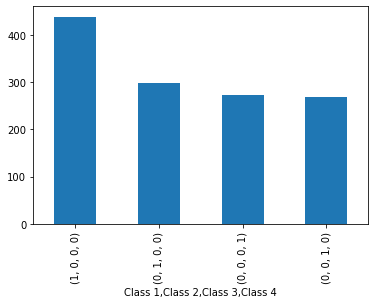

In [4]:
sub_labels_df = pd.DataFrame(sub_labels, columns = ["Class " + str(i+1) for i in range(4)])
sub_labels_df.value_counts().plot(kind='bar');

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_sub_data, sub_labels, test_size=0.25, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(960, 7680, 32)
(320, 7680, 32)
(960, 4)
(320, 4)


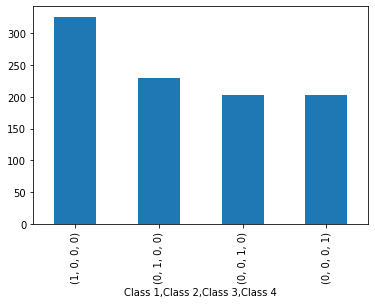

In [7]:
y_train_df = pd.DataFrame(y_train, columns = ["Class " + str(i+1) for i in range(4)])
y_train_df.value_counts().plot(kind='bar');

In [8]:
from sklearn.preprocessing import StandardScaler

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

scaler = StandardScaler()

for instance in range(X_train.shape[0]):
    X_train[instance] = scaler.fit_transform(X_train[instance])

for instance in range(X_test.shape[0]):
    X_test[instance] = scaler.transform(X_test[instance])

In [9]:


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [10]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 50

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: ((None, 7680, 32), (None, 4)), types: (tf.float32, tf.float32)>

In [11]:
from keras import layers
from keras import models
from keras import optimizers

cnn = models.Sequential()

cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu', input_shape=(7680, 32)))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Dropout(0.10))
cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(512, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))

In [12]:
cnn.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [13]:
history = cnn.fit(train_dataset,
          epochs=20,
          batch_size=128,
          validation_data=test_dataset)

Epoch 1/20
8/8 [==============================] - 3s 344ms/step - loss: 3.2611 - accuracy: 0.2656 - val_loss: 1.9546 - val_accuracy: 0.3531
Epoch 2/20
8/8 [==============================] - 2s 312ms/step - loss: 1.3428 - accuracy: 0.3365 - val_loss: 1.7679 - val_accuracy: 0.3063
Epoch 3/20
8/8 [==============================] - 2s 301ms/step - loss: 1.2992 - accuracy: 0.3677 - val_loss: 1.9890 - val_accuracy: 0.3156
Epoch 4/20
8/8 [==============================] - 2s 309ms/step - loss: 1.2147 - accuracy: 0.4740 - val_loss: 2.9936 - val_accuracy: 0.3531
Epoch 5/20
8/8 [==============================] - 2s 305ms/step - loss: 1.1736 - accuracy: 0.5083 - val_loss: 3.2856 - val_accuracy: 0.3469
Epoch 6/20
8/8 [==============================] - 2s 299ms/step - loss: 1.0660 - accuracy: 0.5542 - val_loss: 3.3436 - val_accuracy: 0.3594
Epoch 7/20
8/8 [==============================] - 2s 298ms/step - loss: 0.9676 - accuracy: 0.6094 - val_loss: 4.1672 - val_accuracy: 0.3281
Epoch 8/20
8/8 [====

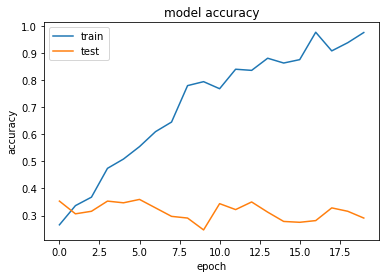

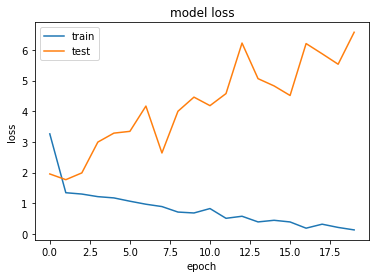

In [14]:
import matplotlib.pyplot as plt

def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot(history)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(all_sub_data, sub_labels, test_size=0.25, random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(960, 8064, 32)
(320, 8064, 32)
(960, 4)
(320, 4)


In [21]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto')

X_train_res, y_train_res = rus.fit_resample(X_train.reshape(960, 32*8064), y_train)
X_test_res, y_test_res = rus.fit_resample(X_test.reshape(320, 32*8064), y_test)

In [22]:
print(X_train_res.shape)
print(X_test_res.shape)
print(y_train_res.shape)
print(y_test_res.shape)

(808, 258048)
(264, 258048)
(808, 4)
(264, 4)


In [23]:
X_train = X_train_res.reshape(808, 8064, 32)
X_test = X_test_res.reshape(264, 8064, 32)
y_train = y_train_res
y_test = y_test_res

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(808, 8064, 32)
(264, 8064, 32)
(808, 4)
(264, 4)


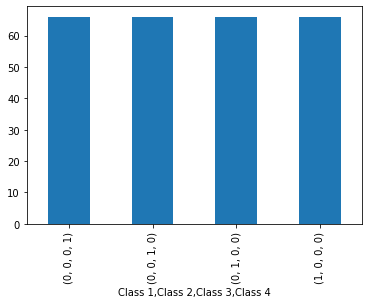

In [25]:
y_test_df = pd.DataFrame(y_test, columns = ["Class " + str(i+1) for i in range(4)])
y_test_df.value_counts().plot(kind='bar');

In [26]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

scaler = StandardScaler()

for instance in range(X_train.shape[0]):
    X_train[instance] = scaler.fit_transform(X_train[instance])

for instance in range(X_test.shape[0]):
    X_test[instance] = scaler.transform(X_test[instance])

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 50

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [27]:
cnn = models.Sequential()

cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu', input_shape=(8064, 32)))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Dropout(0.10))
cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(512, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))
cnn.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [28]:
history = cnn.fit(train_dataset,
          epochs=40,
          batch_size=160,
          validation_data=test_dataset)

Epoch 1/40
7/7 [==============================] - 2s 314ms/step - loss: 5.6744 - accuracy: 0.1498 - val_loss: 1.4203 - val_accuracy: 0.2614
Epoch 2/40
7/7 [==============================] - 2s 302ms/step - loss: 1.4778 - accuracy: 0.2512 - val_loss: 1.3888 - val_accuracy: 0.2614
Epoch 3/40
7/7 [==============================] - 2s 304ms/step - loss: 1.4348 - accuracy: 0.1819 - val_loss: 1.3926 - val_accuracy: 0.2803
Epoch 4/40
7/7 [==============================] - 2s 311ms/step - loss: 1.4218 - accuracy: 0.1646 - val_loss: 1.3986 - val_accuracy: 0.2689
Epoch 5/40
7/7 [==============================] - 2s 296ms/step - loss: 1.4154 - accuracy: 0.1795 - val_loss: 1.3988 - val_accuracy: 0.2576
Epoch 6/40
7/7 [==============================] - 2s 306ms/step - loss: 1.3895 - accuracy: 0.2252 - val_loss: 1.4142 - val_accuracy: 0.2538
Epoch 7/40
7/7 [==============================] - 2s 302ms/step - loss: 1.3942 - accuracy: 0.2537 - val_loss: 1.4164 - val_accuracy: 0.2538
Epoch 8/40
7/7 [====

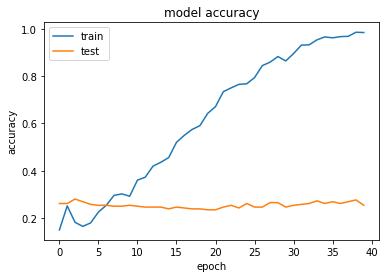

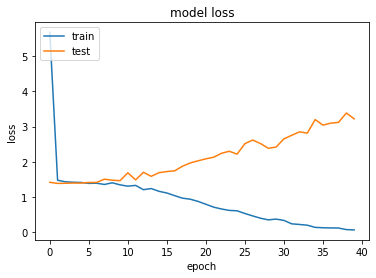

In [29]:
plot(history)

In [30]:
cnn = models.Sequential()

cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu', input_shape=(8064, 32)))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Dropout(0.10))
cnn.add(layers.Conv1D(32, kernel_size=5, strides = 3, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2, strides = 2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(512, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))
cnn.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [31]:
history = cnn.fit(train_dataset,
          epochs=40,
          batch_size=160,
          validation_data=test_dataset)

Epoch 1/40
7/7 [==============================] - 2s 340ms/step - loss: 5.9588 - accuracy: 0.2339 - val_loss: 1.5021 - val_accuracy: 0.2462
Epoch 2/40
7/7 [==============================] - 2s 317ms/step - loss: 1.5555 - accuracy: 0.1510 - val_loss: 1.4436 - val_accuracy: 0.2500
Epoch 3/40
7/7 [==============================] - 2s 317ms/step - loss: 1.4855 - accuracy: 0.1423 - val_loss: 1.4265 - val_accuracy: 0.2500
Epoch 4/40
7/7 [==============================] - 2s 311ms/step - loss: 1.4502 - accuracy: 0.1547 - val_loss: 1.4198 - val_accuracy: 0.2462
Epoch 5/40
7/7 [==============================] - 2s 293ms/step - loss: 1.4343 - accuracy: 0.1795 - val_loss: 1.4160 - val_accuracy: 0.2500
Epoch 6/40
7/7 [==============================] - 2s 299ms/step - loss: 1.3955 - accuracy: 0.2525 - val_loss: 1.4604 - val_accuracy: 0.2500
Epoch 7/40
7/7 [==============================] - 2s 297ms/step - loss: 1.4187 - accuracy: 0.3020 - val_loss: 1.4416 - val_accuracy: 0.2500
Epoch 8/40
7/7 [====

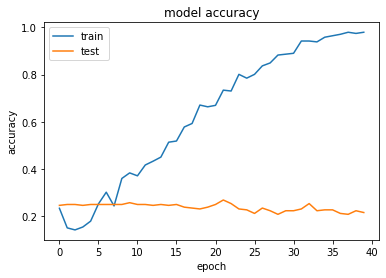

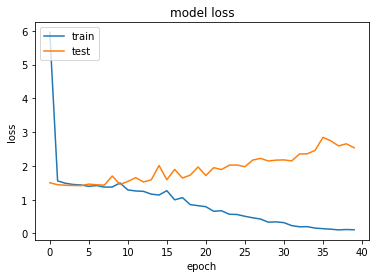

In [32]:
plot(history)